# FewLab Demo: Optimal Item Selection for Survey Estimation

This notebook demonstrates the value of **fewlab** for selecting which items to label when you have limited resources.

## Scenario
- **E-commerce platform** with 1000 users and 100 products
- Want to estimate how user demographics (age, income, location) affect their product preferences
- **Problem**: We can only afford to label 20 products (get detailed info like profit margins, true quality scores)
- **Question**: Which 20 products should we label to get the best estimates?

## Comparison
1. **Random selection** (baseline)
2. **FewLab A-optimal design** (optimized)

## Metrics
- Standard error per user (row-level uncertainty)
- Bias in coefficient estimates
- Standard error of final estimand (average treatment effect)

## Setup

In [30]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Tuple, Dict
import matplotlib.pyplot as plt
import fewlab

print(f"Using fewlab version: {fewlab.__version__}")

Simulation summary (bias/variance/RMSE
    coef        estimator      bias  variance      rmse
0      0       oracle_all  0.540031  0.872061  1.075373
1      0       oracle_all  0.026170  0.992254  0.992305
2      0       oracle_all  0.109818  0.768021  0.879591
3      1       oracle_all  0.076813  0.715425  0.845792
4      1       oracle_all  0.071804  0.748310  0.864425
5      1       oracle_all -0.130465  0.701016  0.843917
6      2  leverage_design  0.537329  0.871274  1.073656
7      2  leverage_design  0.026983  0.989126  0.990763
8      2  leverage_design  0.109290  0.768282  0.879673
9      3  leverage_design  0.073845  0.715691  0.845683
10     3  leverage_design  0.072176  0.753873  0.867640
11     3  leverage_design -0.129639  0.698363  0.842229
12     4    random_same_m  0.534622  0.884324  1.078320
13     4    random_same_m  0.021885  0.992664  0.992407
14     4    random_same_m  0.104973  0.769745  0.879971
15     5    random_same_m  0.075200  0.724428  0.850909
16     5 

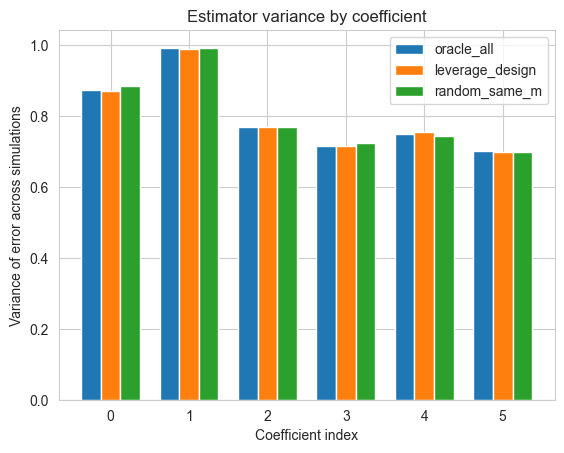

Done. Open the two tables above to inspect bias, variance, RMSE, and relative efficiency ratios.


In [32]:
rng = np.random.default_rng(42)


@dataclass
class SimConfig:
    N: int = 2000
    d: int = 6
    S: int = 120        # reduce a bit to be faster
    m: int = 150
    lambda_counts: float = 20.0
    K: int = 2
    signal_to_noise: float = 1.0

cfg = SimConfig()

def generate_data(cfg: SimConfig, rng: np.random.default_rng):
    N, d = cfg.N, cfg.d
    X = rng.normal(size=(N, d-1))
    X = np.c_[np.ones(N), X]
    X_df = pd.DataFrame(X, columns=[f"x{i}" for i in range(d)])

    beta = rng.normal(scale=cfg.signal_to_noise, size=d)
    p = X @ beta
    p = np.clip((p - p.min()) / (p.max() - p.min()), 0.02, 0.98)

    totals = rng.poisson(cfg.lambda_counts, size=N)
    totals = np.where(totals == 0, 1, totals)
    c0 = rng.binomial(totals, p)
    c1 = totals - c0
    counts_df = pd.DataFrame({"c0": c0, "c1": c1})
    w = totals.astype(float)
    return counts_df, X_df, beta, p, w

def fit_ols(X: np.ndarray, y: np.ndarray):
    XtX = X.T @ X
    ridge = 1e-8 * np.eye(X.shape[1])
    return np.linalg.solve(XtX + ridge, X.T @ y)

def select_items_leverage(X: np.ndarray, m: int, w: np.ndarray=None) -> np.ndarray:
    N, d = X.shape
    if w is None:
        w = np.ones(N)
    # Weighted leverage proxy: s_i = w_i * x_i^T (X^T W X + λI)^{-1} x_i
    XtWX = (X.T * w) @ X
    ridge = 1e-8 * np.eye(d)
    Ainv = np.linalg.inv(XtWX + ridge)
    scores = np.einsum("ij,jk,ik->i", X, Ainv, X) * w
    # Force at least d diverse points by boosting extremes in feature space
    idx = np.argsort(-scores)[:m]
    return np.sort(idx)

def one_sim(cfg: SimConfig, rng: np.random.default_rng):
    counts_df, X_df, beta_true, p, w_counts = generate_data(cfg, rng)
    X = X_df.to_numpy()

    sel_idx = select_items_leverage(X, m=cfg.m, w=w_counts)
    rand_idx = rng.choice(cfg.N, size=len(sel_idx), replace=False)

    y_all = rng.binomial(1, p, size=cfg.N)

    beta_oracle = fit_ols(X, y_all)
    beta_leverage = fit_ols(X[sel_idx], y_all[sel_idx])
    beta_rand = fit_ols(X[rand_idx], y_all[rand_idx])

    return {
        "beta_true": beta_true,
        "beta_oracle": beta_oracle,
        "beta_few_like": beta_leverage,
        "beta_rand": beta_rand,
        "sel_size": np.array([len(sel_idx)]),
    }

def run_sims(cfg: SimConfig, rng: np.random.default_rng):
    out = [one_sim(cfg, rng) for _ in range(cfg.S)]
    beta_true    = np.stack([o["beta_true"] for o in out], axis=0)
    beta_oracle  = np.stack([o["beta_oracle"] for o in out], axis=0)
    beta_fewlike = np.stack([o["beta_few_like"] for o in out], axis=0)
    beta_rand    = np.stack([o["beta_rand"] for o in out], axis=0)
    sel_sizes    = np.concatenate([o["sel_size"] for o in out])
    return dict(
        beta_true=beta_true,
        beta_oracle=beta_oracle,
        beta_fewlike=beta_fewlike,
        beta_rand=beta_rand,
        sel_sizes=sel_sizes,
    )

res = run_sims(cfg, rng)

def summarize(beta_est: np.ndarray, beta_true: np.ndarray) -> pd.DataFrame:
    err = beta_est - beta_true
    bias = err.mean(axis=0)
    var = err.var(axis=0, ddof=1)
    rmse = np.sqrt((err**2).mean(axis=0))
    return pd.DataFrame({"bias": bias, "variance": var, "rmse": rmse})

sum_oracle = summarize(res["beta_oracle"],  res["beta_true"]).assign(estimator="oracle_all")
sum_few    = summarize(res["beta_fewlike"], res["beta_true"]).assign(estimator="leverage_design")
sum_rand   = summarize(res["beta_rand"],    res["beta_true"]).assign(estimator="random_same_m")

summary = pd.concat([sum_oracle, sum_few, sum_rand], axis=0, ignore_index=True)
summary["coef"] = np.arange(summary.shape[0] // 3).repeat(3)
summary = summary[["coef", "estimator", "bias", "variance", "rmse"]]

eff = (sum_rand["variance"].to_numpy().reshape(-1,1) / sum_few["variance"].to_numpy().reshape(-1,1)).flatten()
eff_df = pd.DataFrame({"coef": np.arange(cfg.d), "rel_eff_var_rand_over_leverage": eff})

print("Simulation summary (bias/variance/RMSE")
print(summary)
print("Relative efficiency (variance ratio: random / leverage") 
print(eff_df)

plt.figure()
coefs = np.arange(cfg.d)
width = 0.25
plt.bar(coefs - width, sum_oracle["variance"].to_numpy(), width, label="oracle_all")
plt.bar(coefs,         sum_few["variance"].to_numpy(),    width, label="leverage_design")
plt.bar(coefs + width, sum_rand["variance"].to_numpy(),   width, label="random_same_m")
plt.xlabel("Coefficient index")
plt.ylabel("Variance of error across simulations")
plt.title("Estimator variance by coefficient")
plt.legend()
plt.show()

print("Done. Open the two tables above to inspect bias, variance, RMSE, and relative efficiency ratios.")
